In [26]:
import os
import sys

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))
from src.utils.utils import load_inbreast_mask
from pydicom import dcmread

sns.set_style()

# Radiômica na detecção câncer de mama


## Bancos de imagens de mamografia


<details>
<summary>1. CBIS-DDSM</summary>
<p>
    CBIS-DDSM (Curated Breast Imaging Subset of DDSM)  é uma versão atualizada e padronizada de um banco de imagens de 
    mamografia já existente, o Digital Database for Screening Mammography (DDSM). Essa nova versão do DDSM possui mais de
    1000 estudos. Cada estudo possui a imagem original, o recorte da região de interesse (ROI) e metadados adicionais
    contendo informações das imagens e da patologia, como o diagnóstico da patologia e o nível de Breast Imaging Reporting
    and Data System (BI-RADS), um sistema que promove a padronização os relatórios de patologias mamarias. As imagens do
    banco estão todas no padrão Digital Imaging and Communications in Medicine (DICOM) e possuem resolução de constraste de
    12 ou 16 bits
</p>

[Link](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=22516629)
</details>

<details>
<summary>2. CMMD</summary>
<p>
    O CMMD (Chinese Mammographic Database) é um banco de imagens de mamografia de pacientes da China que foi criado com o 
    objetivo de preencher a lacuna de falta de bancos de dados com indivíduos de raça não branca, assim como a ausência de 
    bancos sem confirmação de biópsia ou subtipos moleculares desconhecidos. Esse banco é composto por exames de 1775 
    pacientes, com média de idade de 47 anos, obtidos no período de 2012 a 2016. Ele possui no total 3712 imagens, todas no 
    padrão DICOM, com qualidade de resolução decontraste de 8 bits. Na base de dados, também são fornecidos metadados adicionais com informações das imagens e da diagnóstico da patologia.
</p>

[Link](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70230508)
</details>

<details>
<summary>3. INBreast</summary>
<p>
    O INBREAST é um banco de imagens de mamografia com imagens obtidas no Centro Hospitalar de S. João (CHSJ), Porto,
    Portugal. Ele foi criado com o propósito de ajudar a desenvolver métodos CAD e superar algumas limitações sofridas pelos
    bancos existentes. O INBREAST possui 115 casos, totalizando 410 imagens no total. As imagens foram adquiridas no
    intervalo de 2008 a 2010, todas no padrão DICOM e possuem qualidade de resolução de contraste de 14 bits. Os metadados
    adicionais fornecem informações sobre a imagem e o nível BI-RADS.
</p>

[Link](https://core.ac.uk/download/pdf/47139244.pdf)<br>
[Link download](https://www.kaggle.com/datasets/ramanathansp20/inbreast-dataset)
</details>

<details>
<summary>4. MIAS</summary>
<p>
    O MIAS (Mammographic Image Analysis Society) é um banco de dados de imagens de mamografia desenvolvido por grupos de 
    pesquisa no Reino Unido. Ele é composto por 161 estudos, totalizando 322 imagens. As imagens nesse banco foram
    inicialmente digitalizadas com uma resolução de pixel de 50 mícrons e posteriormente reduzidas para 200 mícrons devido a 
    solicitações populares. Todas as imagens nesse banco estão no formato PGM (Portable Gray Map) e possuem uma dimensão de 
    imagem de 1024x1024 pixels
</p>

[Link](http://peipa.essex.ac.uk/info/mias.html)
</details>


### Caracterização dos bancos de imagens

In [27]:
cbis_ddsm = pd.read_csv("../../outputs/mamografia/cbis-ddsm/metadata_calc_case_cbis-ddsm.csv")
cbis_ddsm = pd.concat([cbis_ddsm, pd.read_csv('../../outputs/mamografia/cbis-ddsm/metadata_mass_case_cbis-ddsm.csv')],
               axis=0).reset_index(drop=True)
inbreast = pd.read_csv("../../outputs/mamografia/inbreast/metadata_inbreast.csv")
mias = pd.read_csv("../../outputs/mamografia/mias/metadata_mias.csv")
cmmd = pd.read_csv("../../outputs/mamografia/cmmd/metadata_cmmd.csv")

databases = [cbis_ddsm, inbreast, mias, cmmd]
databases_names = ["CBIS DDSDM", "INBreast", "MIAS", "CMMD"]
num_images = [len(db) for db in databases]
images_types = ["DCM", "DCM", "PGM", "DCM"]
images_quality = ["12, 16", "14", "8", "8"]
has_roi = ["Sim", "Sim", "Sim", "Não"]

df = pd.DataFrame({"Banco de imagens": databases_names, "Número de imagens": num_images,
                   "Formato das imagens": images_types,
                    "Qualidade das imagens (bits)": images_quality, "Tem ROI": has_roi})
df

,Banco de imagens,Número de imagens,Formato das imagens,Qualidade das imagens (bits),Tem ROI
0,CBIS DDSDM,3568,DCM,"12, 16",Sim
1,INBreast,410,DCM,14,Sim
2,MIAS,330,PGM,8,Sim
3,CMMD,5590,DCM,8,Não


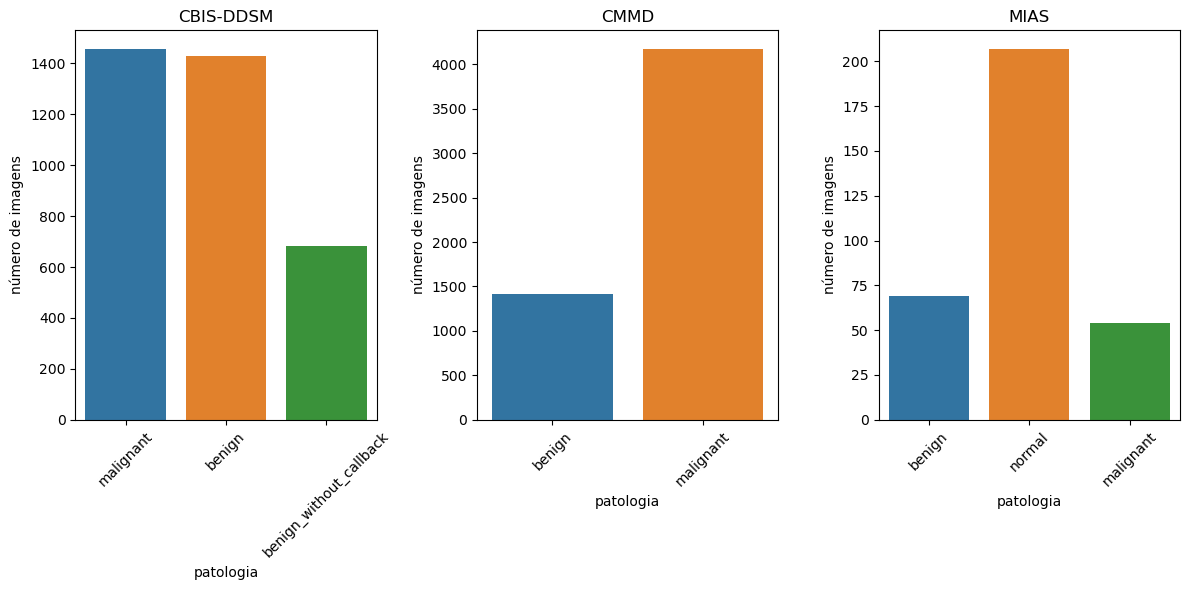

In [28]:
databases = [cbis_ddsm, cmmd, mias]
databases_names = ["CBIS-DDSM", "CMMD", "MIAS"]
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
for i, db in enumerate(databases):
    sns.countplot(x="pathology", data=db, ax=axs[i])
    axs[i].set_title(databases_names[i])
    axs[i].set_xlabel("patologia")
    axs[i].set_ylabel("número de imagens")
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Amostras de imagens dos bancos

#### Funções

In [29]:
def plot_images(images, images_roi=None, images_cropped=None, num_images=3):
    axs = None
    if not images_roi and not images_cropped:
        _, axs = plt.subplots(1, num_images, figsize=(8, 8))
    elif images_roi and images_cropped:
        _, axs = plt.subplots(num_images, 3, figsize=(8, 8))
    elif (not images_roi and images_cropped) or (images_roi and not images_cropped):
        _, axs = plt.subplots(num_images, 2, figsize=(8, 8))

    for i in range(num_images):
        if not images_roi and not images_cropped:
            axs[i].imshow(images[i]['image'], cmap='gray')
            axs[i].set_title(f"Image {images[i]['id']}")
        else:
            axs[i, 0].imshow(images[i]['image'], cmap='gray')
            axs[i, 0].set_title(f"Image {images[i]['id']}")

        if images_roi:
            axs[i, 1].imshow(images_roi[i]['image'], cmap='gray')
            axs[i, 1].set_title(f"ROI {images[i]['id']}")
        if images_cropped and images_roi:
            axs[i, 2].imshow(images_cropped[i]['image'], cmap='gray')
            axs[i, 2].set_title(f"Cropped {images[i]['id']}")
        elif images_cropped and not images_roi:
            axs[i, 1].imshow(images_cropped[i]['image'], cmap='gray')
            axs[i, 1].set_title(f"Cropped {images[i]['id']}")
    plt.tight_layout()
    plt.show()

#### CBIS-DDSM

##### Variáveis

In [30]:
cbis_ddsm_images = cbis_ddsm.loc[:3, ['id','image_path']]
cbis_ddsm_images = [
    {'id': image['id'],
     'image': dcmread(image['image_path']).pixel_array}
    for _, image in cbis_ddsm_images.iterrows()]
cbis_ddsm_images = [
    {'id': image['id'],
     'image': ((image['image'] / image['image'].max()) * 255).astype('uint8')}
    for image in cbis_ddsm_images
]

cbis_ddsm_roi_images = cbis_ddsm.loc[:3, ['id', 'roi_image_path']]
cbis_ddsm_roi_images = [
    {'id': image['id'],
     'image': dcmread(image['roi_image_path']).pixel_array}
    for _, image in cbis_ddsm_roi_images.iterrows()]
cbis_ddsm_roi_images = [
    {'id': image['id'],
     'image': ((image['image'] / image['image'].max()) * 255).astype('uint8')}
    for image in cbis_ddsm_roi_images
]

cbis_ddsm_cropped_images = cbis_ddsm.loc[:3,  ['id', 'cropped_image_path']]
cbis_ddsm_cropped_images = [
    {'id': image['id'],
     'image': dcmread(image['cropped_image_path']).pixel_array}
    for _, image in cbis_ddsm_cropped_images.iterrows()]
cbis_ddsm_cropped_images = [
    {'id': image['id'],
     'image': ((image['image'] / image['image'].max()) * 255).astype('uint8')}
    for image in cbis_ddsm_cropped_images
]

##### Gráfico

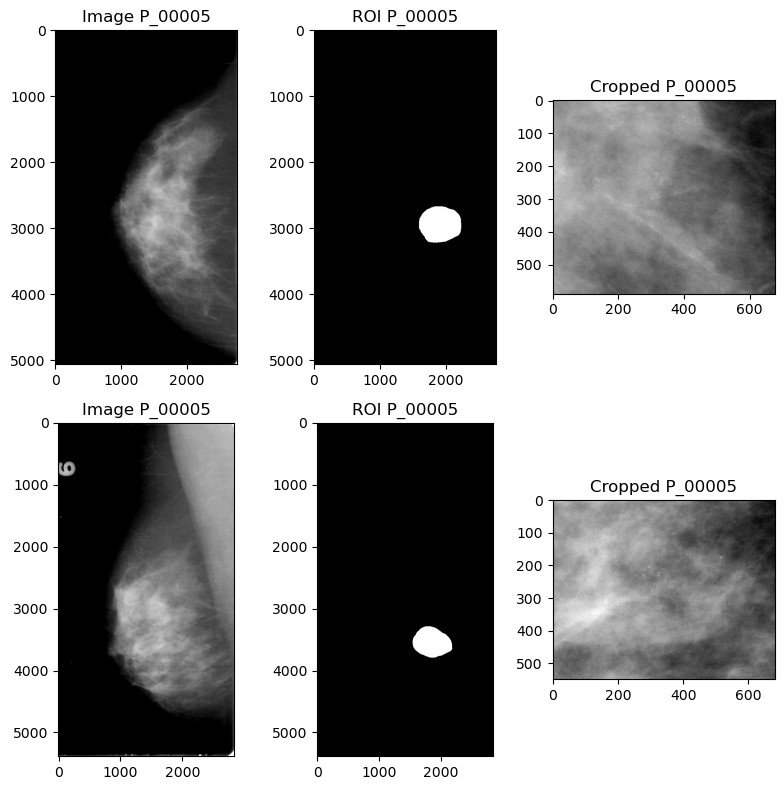

In [31]:

plot_images(cbis_ddsm_images, cbis_ddsm_roi_images, cbis_ddsm_cropped_images, 2)

#### INBreast

##### Variáveis

In [32]:
inbreast_images = inbreast.loc[3:4, ['id','image_path']]
inbreast_images = [
    {'id': image['id'],
        'image': dcmread(image['image_path']).pixel_array}
    for _, image in inbreast_images.iterrows()]

inbreast_images = [
    {'id': image['id'],
        'image': ((image['image'] / image['image'].max()) * 255).astype('uint8')}
    for image in inbreast_images]

inbreast_roi_images = inbreast.loc[3:4, ['id', 'roi_image_path']]
inbreast_roi_images = [
    {'id': image['id'],
        'image': load_inbreast_mask(image['roi_image_path'])}
    for _, image in inbreast_roi_images.iterrows()]

##### Gráfico

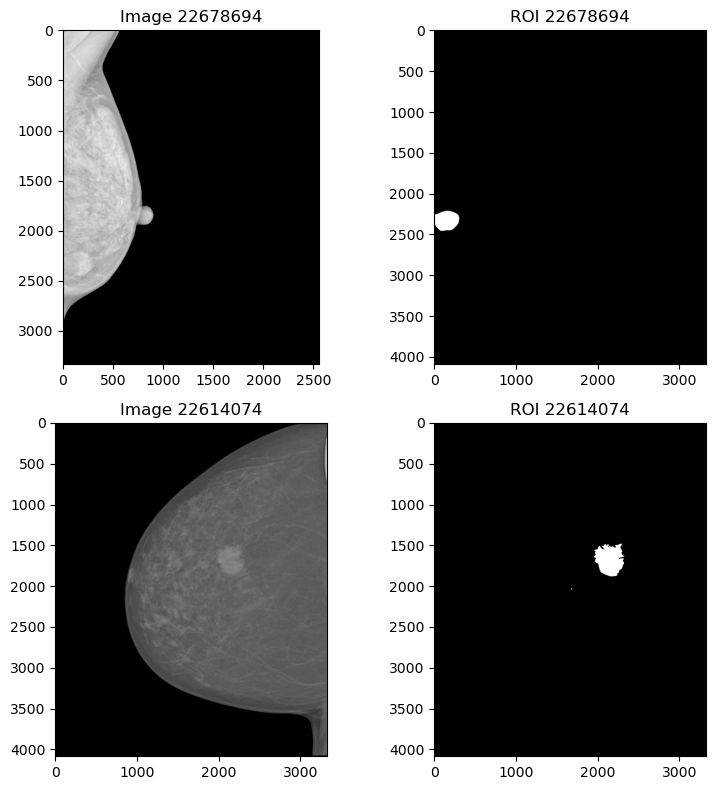

In [33]:
plot_images(inbreast_images, inbreast_roi_images, num_images=2)

#### CMMD

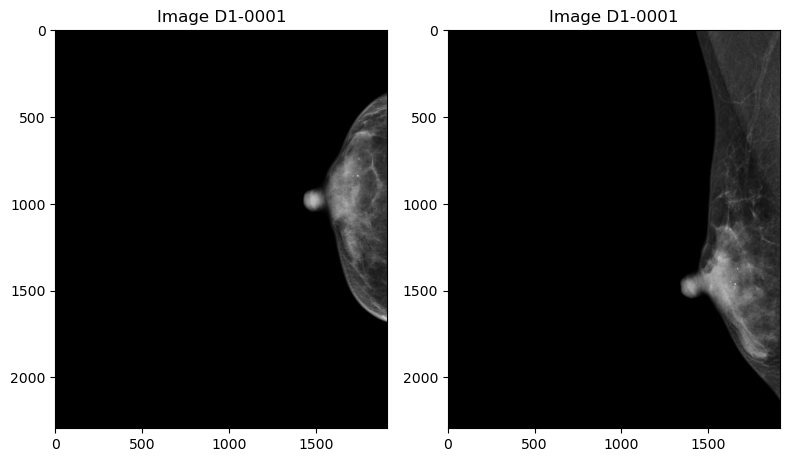

In [34]:
cmmd_images = cmmd.loc[:3, ['id', 'image_path']]
cmmd_images = [
    {'id': image['id'],
        'image': dcmread(image['image_path']).pixel_array}
    for _, image in cmmd_images.iterrows()]

plot_images(cmmd_images, num_images=2)

#### MIAS

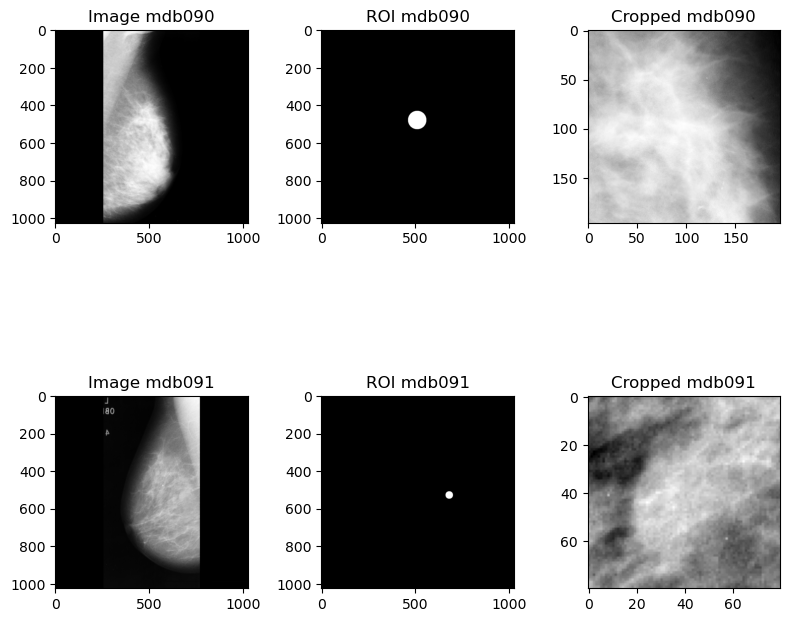

In [35]:
mias_images = mias.loc[90:92, ['id', 'image_path']]
mias_images = [
    {'id': image['id'],
        'image': cv2.imread(image['image_path'], cv2.IMREAD_GRAYSCALE)}
    for _, image in mias_images.iterrows()]

mias_roi_images = mias.loc[90:92, ['id', 'roi_image_path']]
mias_roi_images = [{
    'id': image['id'],
    'image': cv2.imread(image['roi_image_path'], cv2.IMREAD_GRAYSCALE)
} for _, image in mias_roi_images.iterrows()]


mias_cropped_images = mias.loc[90:92, ['id', 'cropped_image_path']]
mias_cropped_images = [{
    'id': image['id'],
    'image': cv2.imread(image['cropped_image_path'], cv2.IMREAD_GRAYSCALE)
} for _, image in mias_cropped_images.iterrows()]

plot_images(mias_images, mias_roi_images, mias_cropped_images, num_images=2)

## Extração de características

### GLCM

__Definição__: (Gray Level Co-occurrence Matrix – GLCM) é a de um método estatístico para descrição de  texturas. A GLCM tem a característica de armazenar a probabilidade de que dois valores de intensidade de cinza estejam envolvidos por uma definida relação espacial. A partir desta matriz de probabilidades diversas medidas estatísticas são retiradas, a fim de caracterizar a textura existente em uma imagem. Entre estas medidas estão contraste, energia, entropia, correlação, homogeneidade, momento de terceira ordem e probabilidade máxima (Büchner, 2020).

Extraímos seis características da GLCM, sendo elas: dissimilaridade, correlação, homogeneidade, contraste, ASM e energia. As características foram obtidas utilizando uma distância de 1 pixel e os ângulos de 0°, 45°, 90° e 135°.

<details>
<summary>Dissimilaridade</summary>
Refere-se à diferença entre os valores dos pixels adjacentes em uma imagem. Quanto maior a dissimilaridade, maior é a variação entre os valores dos pixels próximos.
</details>

<details>
<summary>Correlação</summary>
Indica o grau de correlação entre os valores dos pixels em diferentes direções da imagem. Uma alta correlação significa que os valores dos pixels em diferentes direções estão fortemente relacionados.
</details>

<details>
<summary>Homogeneidade</summary>
Representa a uniformidade dos valores dos pixels em uma imagem. Quanto mais homogênea a imagem, mais os valores dos pixels são semelhantes.
</details>

<details>
<summary>Contraste</summary>
Mede a diferença de intensidade entre os pixels adjacentes na imagem. Um alto contraste indica uma grande variação nos valores dos pixels, enquanto um baixo contraste indica uma variação mínima.
</details>

<details>
<summary>ASM</summary>
Também conhecido como energia, é uma medida da uniformidade da distribuição de intensidades dos pixels na imagem. Quanto maior o ASM, mais uniforme é a distribuição de intensidades dos pixels.
</details>

<details>
<summary>Energia</summary>
Refere-se à soma dos quadrados dos elementos da matriz de coocorrência. É uma medida da magnitude das mudanças de intensidade na imagem. Uma imagem com alta energia possui variações significativas de intensidade, enquanto uma imagem com baixa energia tem poucas variações de intensidade.
</details>

In [36]:
df_glcm = pd.read_csv("../../outputs/mamografia/mias/glcm_features_mias.csv")
df_glcm.head()

,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,correlation_dist_1_ang_0,correlation_dist_1_ang_45,correlation_dist_1_ang_90,correlation_dist_1_ang_135,homogeneity_dist_1_ang_0,homogeneity_dist_1_ang_45,...,contrast_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,pathology
0,0.973884,1.207874,0.818646,1.100704,0.998725,0.998512,0.999711,0.998628,0.717147,0.692236,...,13.136905,0.436872,0.436375,0.441163,0.436264,0.190857,0.190423,0.194625,0.190326,benign
1,1.585178,2.083517,1.511726,1.816926,0.999518,0.999084,0.999534,0.999341,0.499717,0.448010,...,9.150162,0.076132,0.074058,0.077510,0.074861,0.005796,0.005485,0.006008,0.005604,benign
2,1.951363,3.030352,2.238424,2.151287,0.987456,0.969978,0.983172,0.984406,0.387283,0.276267,...,8.114714,0.047273,0.038695,0.044550,0.045281,0.002235,0.001497,0.001985,0.002050,benign
3,1.951363,3.030352,2.238424,2.151287,0.987456,0.969978,0.983172,0.984406,0.387283,0.276267,...,8.114714,0.047273,0.038695,0.044550,0.045281,0.002235,0.001497,0.001985,0.002050,benign
4,1.925804,2.417109,2.163486,2.590991,0.977426,0.964202,0.971384,0.959412,0.384686,0.327495,...,10.947381,0.057407,0.052007,0.054592,0.050196,0.003296,0.002705,0.002980,0.002520,benign


### Características de 1º ordem

Extraímos seis características de 1º ordem, sendo elas:

1. média
2. desvio padrão
3. variância
4. assimetria
5. curtose
6. momento central

In [37]:
df_first_order = pd.read_csv("../../outputs/mamografia/mias/first_order_features_mias.csv")
df_first_order.head()

,mean,std,smoothness,third_moment,uniformity,entropy,pathology
0,48.740517,69.161480,0.999791,358860.22000,0.200536,5.016586,benign
1,141.443480,83.451770,0.999856,-395556.28000,0.012593,7.079600,benign
2,144.866200,16.232676,0.996219,-920.71340,0.018904,5.942641,benign
3,144.866200,16.232676,0.996219,-920.71340,0.018904,5.942641,benign
4,169.276860,11.590163,0.992611,954.18365,0.028183,5.460941,benign
